# Homework 4:  Further Hyper-parameter Tuning  and visualize performance for event detection model

## Notebook Outline

    1. Further Hyper-parameter Tuning for event classification

    2. Visualize the loss and accuracy of the train and validation datasets during training

In [26]:
# Load the tensorflow, which is a framework for deep learning.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# Load numpy library as "np", which can handle large matrices and provides some mathematical functions.
import numpy as np 
# Load pandas as "pd", which is useful when working with data tables. 
import pandas as pd 
# Load the SciPy, which provides many useful tools for scientific computing
import scipy
# Load random, which provide some randomize functions.
import random
# Load a function pyplot as "plt" to plot figures.
import matplotlib.pyplot as plt
# Load functions to calculate precision, and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Load the VAR function for Vector Autoregression
from statsmodels.tsa.api import VAR

# Setup the random seed for reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)

In [2]:
# The root directory of the pmuBAGE data
pmuBAGE_data_dir = "pmuBAGE/data"

# Number of the tensor for voltage and frequency
voltage_tensor_number = 31
frequency_tensor_number = 21

# Load each tensors of voltage events and concatenate them as a big tensor.
voltage_tensor_list = []
for idx in range(voltage_tensor_number):
    voltage_sub_tensor = np.load(f"{pmuBAGE_data_dir}/voltage/voltage_{idx}.npy")
    voltage_tensor_list.append(voltage_sub_tensor)
voltage_tensor = np.concatenate(voltage_tensor_list, axis=0)


# Load each tensors of frequency events and concatenate them as a big tensor.
frequency_tensor_list = []
for idx in range(frequency_tensor_number):
    frequency_sub_tensor = np.load(f"{pmuBAGE_data_dir}/frequency/frequency_{idx}.npy")
    frequency_tensor_list.append(frequency_sub_tensor)
frequency_tensor = np.concatenate(frequency_tensor_list, axis=0)

# Transpose the big tensor as (event_idx, timestamp, PMU_idx, measurements)
voltage_tensor = np.transpose(voltage_tensor, (0, 3, 2, 1))
frequency_tensor = np.transpose(frequency_tensor, (0, 3, 2, 1))

# Print the shape of the voltage event
print(voltage_tensor.shape)
print(frequency_tensor.shape)

(620, 600, 100, 4)
(84, 600, 100, 4)


In [3]:
"""
    Use standardization to pre-process the pmu time series data.
    Input  -> two original tensors: voltage_tensor, frequency_tensor
    Output -> two standardized tensors: voltage_tensor_standardized, frequency_tensor_standardized
    Requirement Details: 
        The tensor shape is (number_of_event, timestamps (600), pmus (100), measurements (4))
        For each time sequence (Single pmu measurement sequence, 600 timestamps), standardize them by Z-Score
        z-score = (x - mean) / std
"""

# Voltage tensor

voltage_mean = np.mean(voltage_tensor, axis=1)
voltage_mean = np.expand_dims(voltage_mean, axis=1)
voltage_std = np.std(voltage_tensor, axis=1)
voltage_std = np.expand_dims(voltage_std, axis=1)
voltage_tensor_standardized = np.nan_to_num((voltage_tensor - voltage_mean) / voltage_std)

# Frequency tensor

frequency_mean = np.mean(frequency_tensor, axis=1)
frequency_mean = np.expand_dims(frequency_mean, axis=1)
frequency_std = np.std(frequency_tensor, axis=1)
frequency_std = np.expand_dims(frequency_std, axis=1)
frequency_tensor_standardized = np.nan_to_num((frequency_tensor - frequency_mean) / frequency_std)

print(voltage_tensor_standardized.shape)
print(frequency_tensor_standardized.shape)


(620, 600, 100, 4)
(84, 600, 100, 4)


In [4]:
# Number of the classes
num_classes = 2

# Number of the voltage and frequency events in the dataset
n_voltage = voltage_tensor_standardized.shape[0]
n_frequency = frequency_tensor_standardized.shape[0]

# Define the labels
# Voltage events' label is defined as: 0
voltage_label = np.array([0] * n_voltage)
# Frequency events' label is defined as: 1
frequency_label = np.array([1] * n_frequency)

"""
    Implement the one-hot encoding on the lablel of of the voltage and frequency event labels.
    Input  -> Original voltage and frequency labels (voltage_label, frequency_label)
    Output -> One-hot encoded voltage and frequency labels (voltage_label_onehot, frequency_label_onthot)
    Voltage label: "0" -> "[1, 0]"
    Frequency label: "1" -> "[0, 1]"
    You can use any library or tool for doing this
"""

voltage_label_onehot = tf.keras.utils.to_categorical(voltage_label, num_classes=num_classes)
frequency_label_onthot = tf.keras.utils.to_categorical(frequency_label, num_classes=num_classes)

# Should be [1, 0]
print(voltage_label_onehot[0])
# Should be [0, 1]
print(frequency_label_onthot[0])
# Should be (620, 2)
print(voltage_label_onehot.shape)
# Should be (84, 2)
print(frequency_label_onthot.shape)

[1. 0.]
[0. 1.]
(620, 2)
(84, 2)


In [5]:
voltage_tensor_standarded_permuted = voltage_tensor_standardized[np.random.permutation(n_voltage)]
frequency_tensor_standarded_permuted = frequency_tensor_standardized[np.random.permutation(n_frequency)]

In [6]:
# Seperate the data to train and test
train_portion = 0.7

# Samples
X_voltage = voltage_tensor_standarded_permuted
X_frequency = frequency_tensor_standarded_permuted
# Labels
y_voltage = voltage_label_onehot
y_frequency = frequency_label_onthot

"""
    Seperate the samples and labels to train and test datasets.
    70% of the voltage and frequency samples and labels are combined as training dataset
    30% remainings are combined as testing dataset
    Input  -> X_voltage, X_frequency, y_voltage, y_frequency
    Output -> X_train, y_train, X_test, y_test
        X_train contains 70% of the X_voltage and X_frequency
        y_train contains 70% of the y_voltage and y_frequency
        X_test contains 30% of the X_voltage and X_frequency
        y_test contains 30% of the y_voltage and y_frequency
"""

# X_train
X_train_voltage = X_voltage[:int(n_voltage * train_portion)] 
X_train_frequency = X_frequency[:int(n_frequency * train_portion)]
X_train = np.concatenate([X_train_voltage, X_train_frequency], axis=0)

# y_train
y_train_voltage = y_voltage[:int(n_voltage * train_portion)] 
y_train_frequency = y_frequency[:int(n_frequency * train_portion)]
y_train = np.concatenate([y_train_voltage, y_train_frequency], axis=0)

# X_test
X_test_voltage = X_voltage[int(n_voltage * train_portion):] 
X_test_frequency = X_frequency[int(n_frequency * train_portion):]
X_test = np.concatenate([X_test_voltage, X_test_frequency], axis=0)

# y_test
y_test_voltage = y_voltage[int(n_voltage * train_portion):] 
y_test_frequency = y_frequency[int(n_frequency * train_portion):]
y_test = np.concatenate([y_test_voltage, y_test_frequency], axis=0)


"""
    Seperate the Training Dataset to Training (80%) and Validation (20%).
    Perform the hyper-parameter tuning to find the best parameter combination.
    
"""

val_portaton = 0.2

n_voltage_train = int(n_voltage * train_portion)
n_frequency_train = int(n_frequency * train_portion)

X_train_voltage = X_voltage[:int(n_voltage * train_portion)] 
X_train_frequency = X_frequency[:int(n_frequency * train_portion)]
X_train = np.concatenate([X_train_voltage, X_train_frequency], axis=0)

# X_val_hp
X_val_hp_voltage = X_train[:int(n_voltage_train * val_portaton)]
X_val_hp_frequency = X_train[n_voltage_train: n_voltage_train + int(n_frequency_train * val_portaton)]
X_val_hp = np.concatenate([X_val_hp_voltage, X_val_hp_frequency], axis=0)

# y_val_hp
y_val_hp_voltage = y_train[:int(n_voltage_train * val_portaton)]
y_val_hp_frequency = y_train[n_voltage_train: n_voltage_train + int(n_frequency_train * val_portaton)]
y_val_hp = np.concatenate([y_val_hp_voltage, y_val_hp_frequency], axis=0)


# X_train_hp
X_train_hp_voltage = X_train[int(n_voltage_train * val_portaton): n_voltage_train]
X_train_hp_frequency = X_train[n_voltage_train + int(n_frequency_train * val_portaton):]
X_train_hp = np.concatenate([X_train_hp_voltage, X_train_hp_frequency], axis=0)

# y_train_hp
y_train_hp_voltage = y_train[int(n_voltage_train * val_portaton): n_voltage_train]
y_train_hp_frequency = y_train[n_voltage_train + int(n_frequency_train * val_portaton):]
y_train_hp = np.concatenate([y_train_hp_voltage, y_train_hp_frequency], axis=0)


X_train, y_train = X_train_hp, y_train_hp
X_val, y_val = X_val_hp, y_val_hp


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (395, 600, 100, 4)
y_train shape: (395, 2)
X_val shape: (97, 600, 100, 4)
y_val shape: (97, 2)
X_test shape: (212, 600, 100, 4)
y_test shape: (212, 2)


## 1. Further Hyper-parameter Tuning for event classification

In [7]:
def build_model():
    """
        Feel free to change the structure of the model
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(600, 100, 4)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [14]:
# Further Hyper-parameters

learning_rates = [0.001, 0.01]
batch_sizes = [15, 30]
training_epochs = [15, 25]


##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##


"""
    Try different combination of the hyper-parameters. 
    Using grid search to get the best hyper-parameters
    Choose the best hyper-parameter combination to train the final model.
    Pick your own hyper-parameters and search range.
"""

best_hyperparameter = {"learning_rate": 0, "batch_size": 0, "training_epoch": 0}
best_accuracy_val = 0.0


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for training_epoch in training_epochs:
            print(f"Current hyper-parameters: learning_rate: {learning_rate}, batch_size: {batch_size}, training_epoch: {training_epoch}.")
            
            
            # build model
            model_tuning = build_model()

            # Train the model with the above hyper-parameters

            # Define the optimizer and learning rate
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

            # Define the Loss function
            loss_func = tf.keras.losses.CategoricalCrossentropy()

            # Compile the neural network model
            model_tuning.compile(optimizer=optimizer, loss=loss_func, metrics=['categorical_accuracy'])

            # Train the neural network
            history = model_tuning.fit(X_train_hp, y_train_hp, epochs= training_epoch, batch_size= batch_size)

    
            # Evaluate the hyper-parameter tuning neural network
            loss_val, accuracy_val = model_tuning.evaluate(X_val_hp, y_val_hp)
            print(f"Current validation accuracy is: {accuracy_val}.\n")
            
            if accuracy_val > best_accuracy_val:
                best_accuracy_val = accuracy_val
                best_hyperparameter["learning_rate"] = learning_rate
                best_hyperparameter["batch_size"] = batch_size
                best_hyperparameter["training_epoch"] = training_epoch
            tf.keras.backend.clear_session()

print(f"best validation accuracy is: {best_accuracy_val}")
print(f"best hyper-parameter setting is: {best_hyperparameter}")

##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##


Current hyper-parameters: learning_rate: 0.001, batch_size: 15, training_epoch: 15.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 696ms/step - categorical_accuracy: 0.8094 - loss: 0.5671
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 624ms/step - categorical_accuracy: 0.8717 - loss: 0.2324
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 629ms/step - categorical_accuracy: 0.9411 - loss: 0.1517
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 730ms/step - categorical_accuracy: 0.9586 - loss: 0.1453
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 672ms/step - categorical_accuracy: 0.9632 - loss: 0.1400
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step - categorical_accuracy: 0.9488 - loss: 0.1164
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - categorical_accuracy: 0.9693 - loss: 0.1185
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 582ms/step - categorical_accuracy: 0.9920 - loss: 0.1114
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - categorical_accuracy: 0.9841 - loss: 0.0976
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 943ms/step - categorical_accuracy: 0.9886 - loss: 0.0715
Epoch 11/15


## 2. Visualize the loss and accuracy of the train and validation datasets during training

In [33]:
##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

"""
    Using the best hyper-parameters get from the previous step and train the final model.
"""
from tensorflow.keras.callbacks import EarlyStopping


#####################################
######     Improved Model      ######
#####################################

learning_rate = 0.001
batch_size = 15
training_epoch = 25


# Build model
model_improved = build_model()
# Define the loss function
loss_func = tf.keras.losses.CategoricalCrossentropy()
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# Compile the model
model_improved.compile(optimizer=optimizer, loss=loss_func, metrics=['categorical_accuracy'])


# Define the early stopping callback
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 10, restore_best_weights = True)

# Train the model with the tuned hyper-parameters and early-stopping.
history = model_improved.fit(X_train_hp, y_train_hp, validation_data=(X_val_hp, y_val_hp), 
                             epochs=training_epoch, batch_size=batch_size, callbacks=[early_stopping])



##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 627ms/step - categorical_accuracy: 0.8240 - loss: 1.6742 - val_categorical_accuracy: 0.9485 - val_loss: 0.1789
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 621ms/step - categorical_accuracy: 0.9680 - loss: 0.2031 - val_categorical_accuracy: 0.9588 - val_loss: 0.1581
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 625ms/step - categorical_accuracy: 0.9625 - loss: 0.1392 - val_categorical_accuracy: 0.8969 - val_loss: 0.4440
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 621ms/step - categorical_accuracy: 0.9250 - loss: 0.1870 - val_categorical_accuracy: 0.9485 - val_loss: 0.1782
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 621ms/step - categorical_accuracy: 0.9697 - loss: 0.0939 - val_categorical_accuracy: 0.9691 - val_loss: 0.1340
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 628ms/step - categorical_accuracy: 0.9601 - loss: 0.0970 - val_categorical_accuracy: 0.9691 - val_loss: 0.1721
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 625ms/step - categorical_accuracy: 0.979

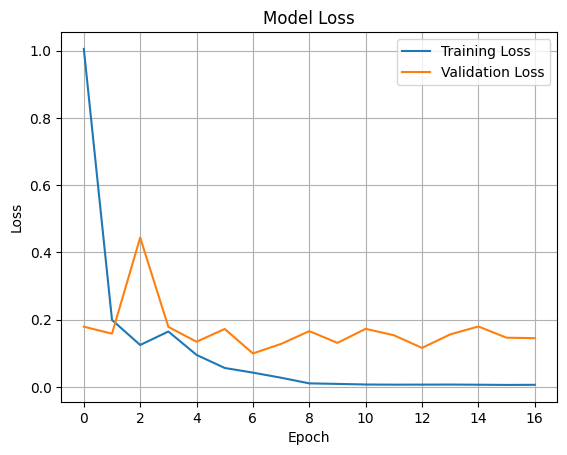

In [34]:
##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

"""
    Plot the loss of the training and validation datasets changes during the training.
    The information of the loss during the training is stored in "history" (return from model.fit()).
    Useful resource: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
"""


# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##

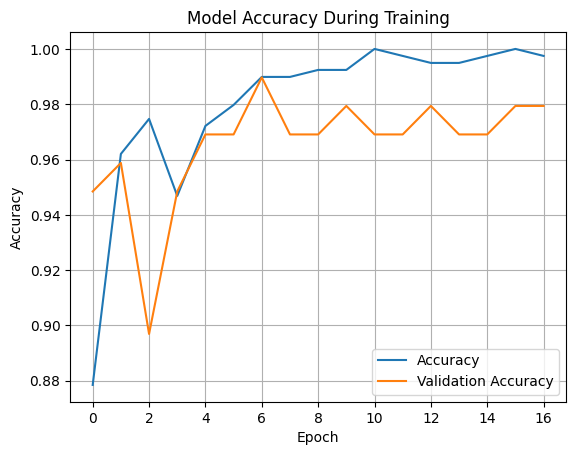

In [35]:
##-----------------------------------------------------------------------##
##---------------------Students start filling below----------------------##
##-----------------------------------------------------------------------##

"""
    Plot the accuracy on the training and validation datasets during the training.
    The information of the accuracy during the training is stored in "history" (return from model.fit()).
    Useful resource: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
"""


acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()
plt.close()

##-----------------------------------------------------------------------##
##------------------------------End filling------------------------------##
##-----------------------------------------------------------------------##